In [1]:
import util
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import random
from ipywidgets import interact
from collections import defaultdict, Counter
from scipy.spatial import distance
from scipy.cluster import hierarchy
from numpy import mean
from functools import partial

In [2]:
path_data = "./data/"
path_media = "./media/"

In [3]:

ng1_raw = util.load_file(path_data + "1_10.json")
ng2_raw = util.load_file(path_data + "2_10.json")
ng3_raw = util.load_file(path_data + "3_10.json")
ng4_raw = util.load_file(path_data + "4_10.json")

In [4]:
punctuation = " \n\t.,;:|()[]\{\}\xa0'’‘\"”“?!"
ng1 = defaultdict(int)
for k,v in ng1_raw.items():
    if k not in punctuation:
        ng1[k.lower()] += v

In [5]:
ng2 = defaultdict(int)
for (kl,kr),v in ng2_raw.items():
    if kl not in punctuation and kr not in punctuation:
        ng2[(kl+kr).lower()] += v

for (kl,kc,kr),v in ng3_raw.items():
    if kc in punctuation and kl not in punctuation and kr not in punctuation:
        ng2[(kl+kr).lower()] += v
ng3 = defaultdict(int)

for (kl,kc,kr),v in ng3_raw.items():
    if kl not in punctuation and kc not in punctuation and kr not in punctuation:
        ng3[(kl+kc+kr).lower()] += v

for (kl,kcl,kcr,kr),v in ng4_raw.items():
    if kcl in punctuation:
        if kcr in punctuation:
            if kl not in punctuation and kr not in punctuation:
                ng2[(kl+kr).lower()] += v
        elif kl not in punctuation and kr not in punctuation:
            ng3[(kl+kcr+kr).lower()] += v
    elif kcr in punctuation:
        ng3[(kl+kcl+kr).lower()] += v


In [6]:
elements = [k for k,v in ng1.items()][:40]# + ["+","<",">","×"]
print(elements)

['e', 'a', 't', 'i', 'n', 'o', 'r', 's', 'l', 'h', 'd', 'c', 'u', 'm', 'f', 'g', 'p', 'y', 'w', 'b', 'v', '1', 'k', '0', '2', '9', '-', '8', 'x', '3', '5', '6', '7', '4', 'j', 'z', '–', 'q', '=', '/']


In [7]:
elements = sorted(elements)
elements_dict = {k:i for i,k in enumerate(elements)}

In [8]:
total = sum([ng1[e] for e in elements])

In [9]:
a_M = util.build_term_context_matrix(elements, elements, ng2)
a_M = a_M.toarray()
a_pmi = util.pmi_matrix(elements,elements,ng1,ng2,ng3,total,independent=False)

Building oR Matrix...
Term-Context Matrix built in 0.03 secs.



findfont: Font family ['Courier'] not found. Falling back to DejaVu Sans.


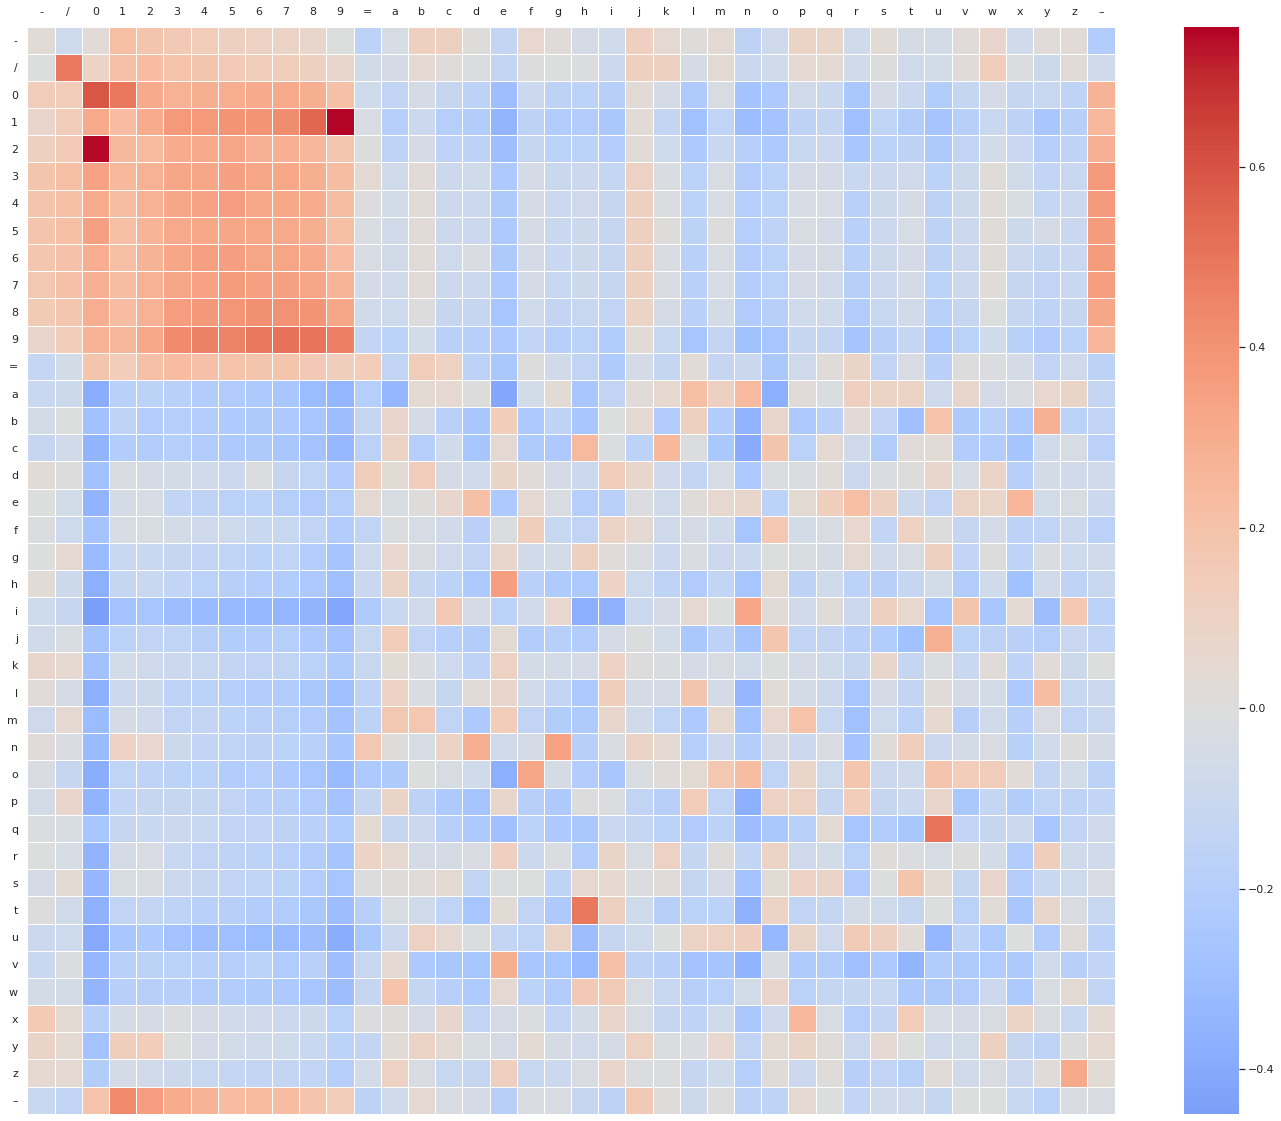

In [10]:
util.plot(a_pmi,elements,elements);

In [11]:
# plt.savefig(path_media + "pmi_matrix.pdf")

In [12]:
methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
method = "ward"
row_linkage = hierarchy.linkage(
    distance.pdist(a_pmi), method=method)

col_linkage = hierarchy.linkage(
    distance.pdist(a_pmi.T), method=method)

sym_linkage = hierarchy.linkage(
    distance.pdist(a_pmi+a_pmi.T), method=method)

In [13]:
fig = plt.figure(figsize=(25, 5))
plt.rcParams.update({'axes.facecolor':'white'})
# plt.rcdefaults()
@interact(p=(1,len(elements),1), truncate_mode = ["lastp", "level"], save = False)
def h_clus_cols(p=len(elements),truncate_mode = "lastp", save = False):
    plt.figure(figsize=(25, 5))
    hierarchy.dendrogram(
        sym_linkage, #col_linkage,
        labels=elements,
        p = p,
        color_threshold = 3,
        truncate_mode = truncate_mode, #"lastp", #'lastp', None, "level"
        leaf_label_func=partial(util.llf, sym_linkage, elements),
        leaf_rotation=0,
        get_leaves = True
        );
    plt.grid(b=True, which='major', axis='y',color='lightgrey', linestyle='-', linewidth=.1)
    plt.xlabel('Clusters',fontsize=16)
    plt.ylabel(f'distance ({method})',fontsize=16)
    plt.xticks(fontfamily="monospace",fontsize=10),
    if save:
        plt.savefig(path_media + "dendrogram.pdf");

<Figure size 1800x360 with 0 Axes>

interactive(children=(IntSlider(value=40, description='p', max=40, min=1), Dropdown(description='truncate_mode…

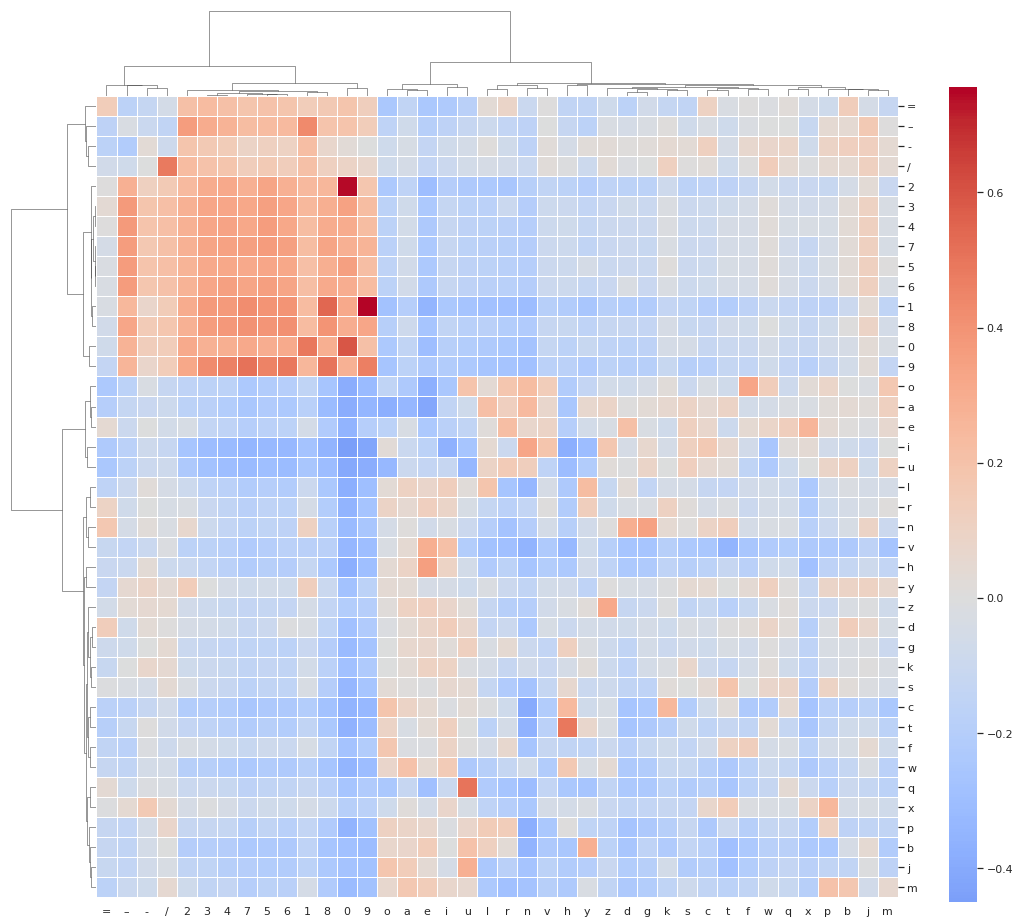

In [14]:
hc_heatmap = sns.clustermap(
    a_pmi,
    row_linkage=sym_linkage,#row_linkage,
    col_linkage=sym_linkage,#col_linkage,
    method="ward",
    xticklabels = elements,
    yticklabels = elements,
    center = 0,
    figsize=(13, 13),
    dendrogram_ratio=(.1, .1),
    linewidths=.5,
    cmap="coolwarm",
    cbar_pos=(1.02, 0.03, .03, .87),
    );
plt.setp(hc_heatmap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

In [15]:
# hc_heatmap.savefig(path_media + "hcluster_normPMI.pdf")

In [16]:
def type_matrix(row_thres=2,col_thres=2):

    cluster_labels_rows = hierarchy.fcluster(row_linkage, row_thres, criterion='distance')
    cluster_labels_cols = hierarchy.fcluster(col_linkage, col_thres, criterion='distance')
    cluster_labels_sym = hierarchy.fcluster(sym_linkage, col_thres, criterion='distance')
    cluster_labels_rows = cluster_labels_sym
    cluster_labels_cols = cluster_labels_sym

    max_cluster_rows = max(cluster_labels_rows)
    max_cluster_cols = max(cluster_labels_cols)

    reduced_rows = np.vstack([mean(a_pmi[cluster_labels_rows==cluster],axis=0) for cluster in range(1,max_cluster_rows+1)])
    reduced_rows_labels = [" ".join(np.array(elements)[cluster_labels_rows==cluster].tolist()) for cluster in range(1,max_cluster_rows+1)]

    reduced_cols = np.vstack([mean(reduced_rows[:,cluster_labels_cols==cluster],axis=1).T for cluster in range(1,max_cluster_cols+1)]).T
    reduced_cols_labels = [" ".join(np.array(elements)[cluster_labels_cols==cluster].tolist()) for cluster in range(1,max_cluster_cols+1)]
    reduced_rows_labels = [label[:int(len(label)/2)] + "\n" + label[int(len(label)/2):] if len(label)>5 else label for label in reduced_rows_labels]

    reduced_cols_labels = [label[:int(len(label)/2)] + "\n" + label[int(len(label)/2):] if len(label)>5 else label for label in reduced_cols_labels]
    sns.set(
        rc = {'figure.figsize':(10,10)},
        font="Courier"
        )
    matrix_plot = util.plot(reduced_cols,reduced_cols_labels,reduced_rows_labels)
    return matrix_plot

In [17]:
row_max = max(row_linkage[:,2])
row_min = min(row_linkage[:,2])
col_max = max(col_linkage[:,2])
col_min = min(col_linkage[:,2])


interact(type_matrix, row_thres=(row_min, row_max, .01), col_thres=(col_min,col_max,.01));

interactive(children=(FloatSlider(value=2.0, description='row_thres', max=6.938287937614307, min=0.10270496279…

In [18]:
cluster_labels_rows = hierarchy.fcluster(row_linkage, 2, criterion='distance')
cluster_labels_cols = hierarchy.fcluster(col_linkage, 2, criterion='distance')

max_cluster_rows = max(cluster_labels_rows)
max_cluster_cols = max(cluster_labels_cols)
reduced_rows = np.vstack([np.mean(a_pmi[cluster_labels_rows==cluster],axis=0) for cluster in range(1,max_cluster_rows+1)])
reduced_rows_labels = [" ".join(np.array(elements)[cluster_labels_rows==cluster].tolist()) for cluster in range(1,max_cluster_rows+1)]

reduced_cols = np.vstack([np.mean(reduced_rows[:,cluster_labels_cols==cluster],axis=1).T for cluster in range(1,max_cluster_cols+1)]).T
reduced_cols_labels = [" ".join(np.array(elements)[cluster_labels_cols==cluster].tolist()) for cluster in range(1,max_cluster_cols+1)]

reduced_rows_labels = [label[:int(len(label)/2)] + "\n" + label[int(len(label)/2):] if len(label)>5 else label for label in reduced_rows_labels]

reduced_cols_labels = [label[:int(len(label)/2)] + "\n" + label[int(len(label)/2):] if len(label)>5 else label for label in reduced_cols_labels]

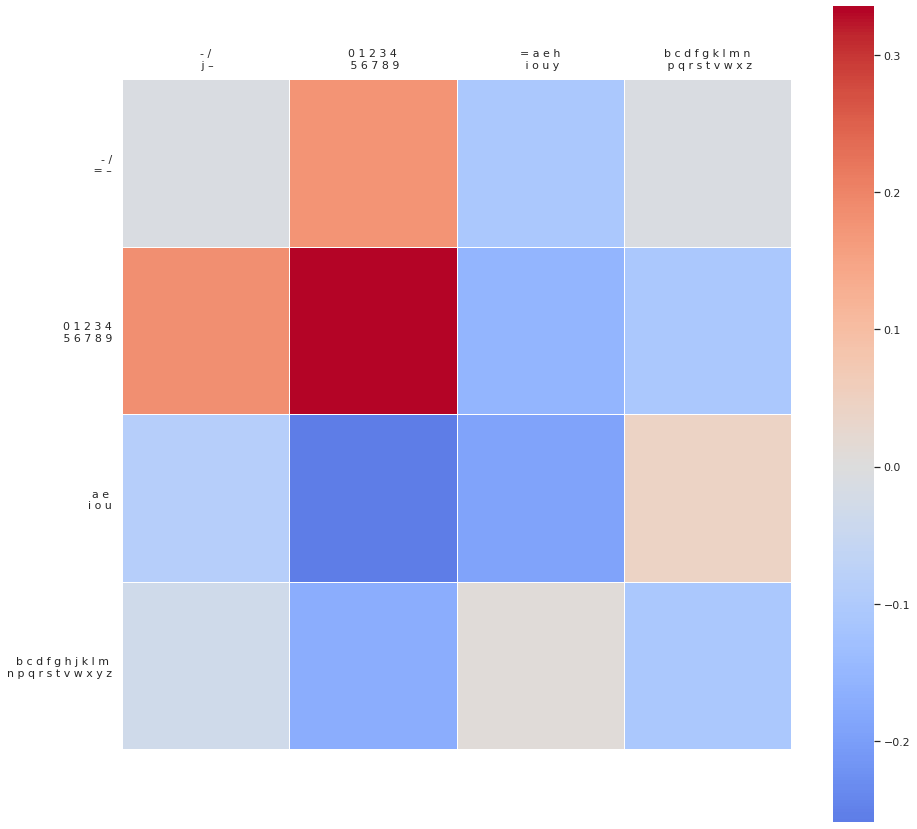

In [19]:
sns.set(
    rc = {'figure.figsize':(15,15)},
    font="Courier"
    )
util.plot(reduced_cols,reduced_cols_labels,reduced_rows_labels, save = "/Users/Gianni/Desktop/type_matrix.pdf")

In [21]:
# plt.savefig(path_media + "type_matrix.pdf")

In [22]:
terms = elements + random.sample([str(i) for i in range(10,100)],10) + random.sample([i+j for i in elements for j in elements],10)
contexts = elements

# terms = list(string.ascii_lowercase) + [i+j for i in string.ascii_lowercase for j in string.ascii_lowercase]
# contexts = list(string.ascii_lowercase)

matrix_R = util.pmi_matrix(terms,contexts, ng1, ng2, ng3, total, independent=False, context_side="right")
matrix_L = util.pmi_matrix(terms,contexts, ng1, ng2, ng3, total, independent=False, context_side="left")

matrixLR = (matrix_R + matrix_L)/2

In [23]:
methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
method = "ward"
row_linkage_2d = hierarchy.linkage(
    distance.pdist(matrixLR), method=method)

col_linkage_2d = hierarchy.linkage(
    distance.pdist(matrixLR.T), method=method)

/usr/local/lib/python3.9/site-packages/seaborn/matrix.py:1216: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


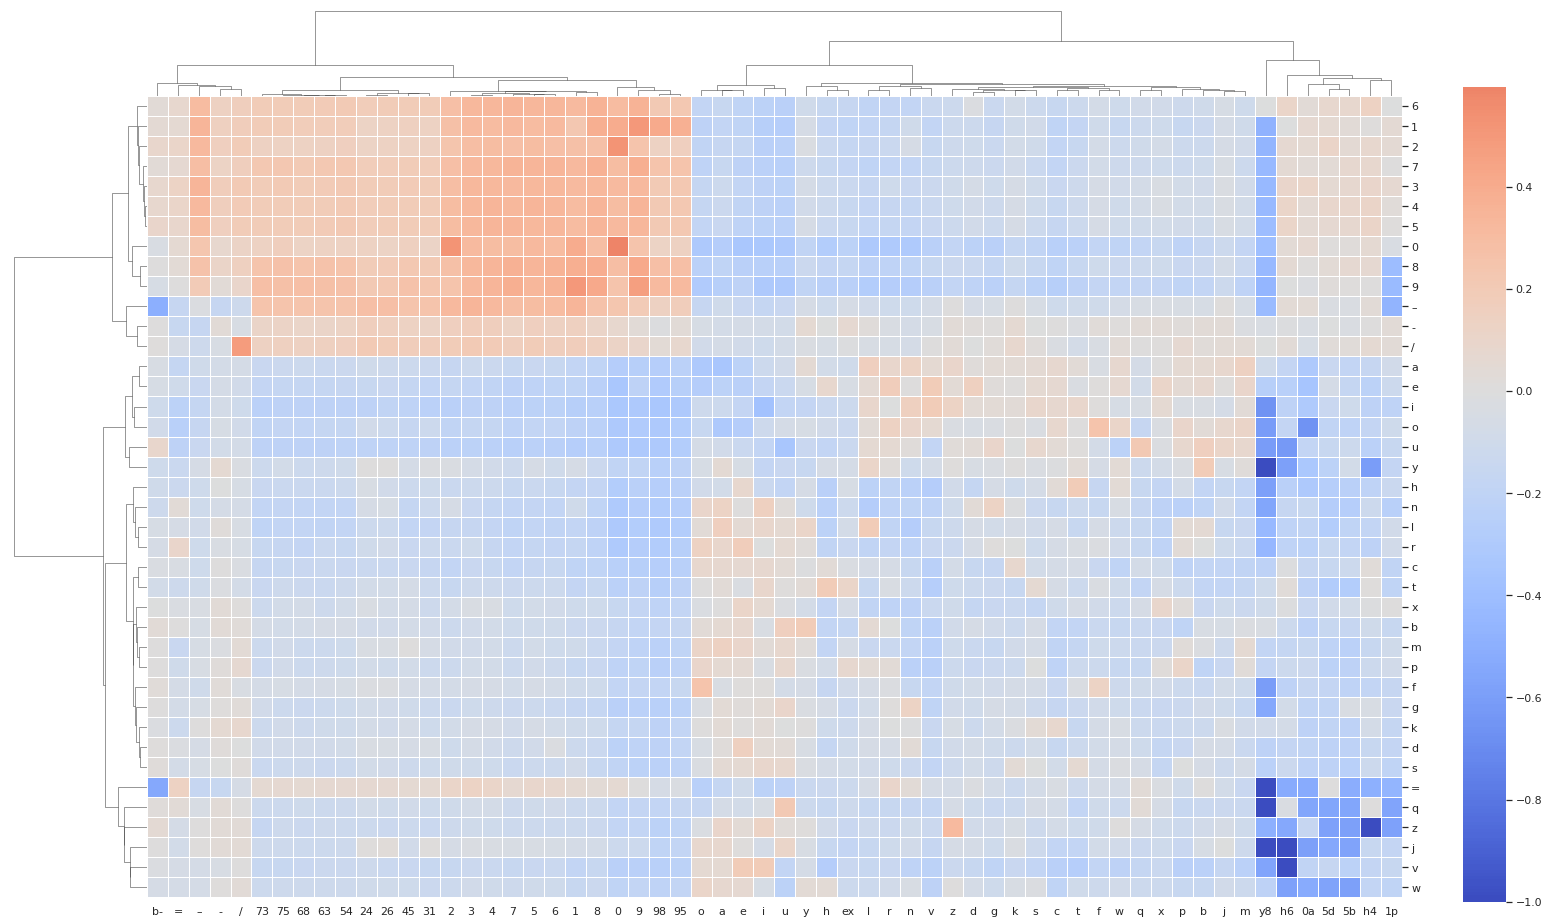

In [24]:
hcluster_normPMI_2d = sns.clustermap(
    matrixLR.T,
    row_linkage=col_linkage_2d,
    col_linkage=row_linkage_2d,
    method="ward",
    yticklabels = contexts,
    xticklabels = terms,
    center = 0,
    figsize=(20, 13),
    dendrogram_ratio=(.1, .1),
    linewidths=.5,
    cmap="coolwarm",
    cbar_pos=(1.02, 0.03, .03, .87),
    square=True,)
plt.setp(hcluster_normPMI_2d.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

In [25]:
# hcluster_normPMI_2d.savefig(path_media + "hcluster_normPMI_2d.pdf")

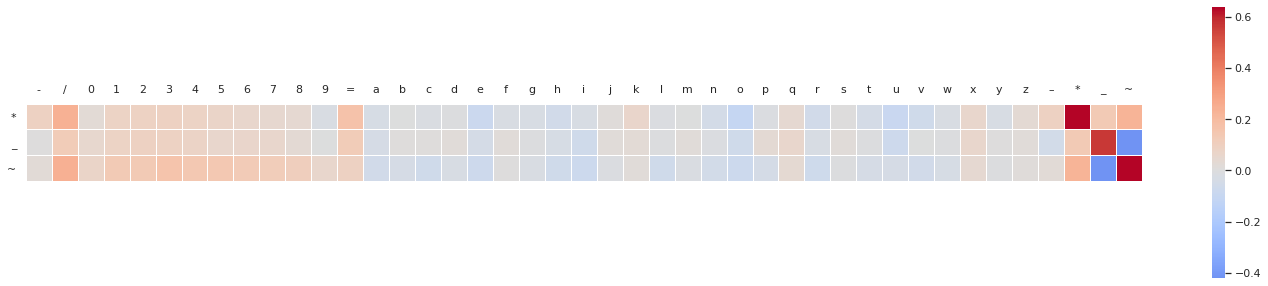

In [26]:
inds = ["*","_","~"]
matrix_ind_R = util.pmi_matrix(inds,contexts+inds, ng1, ng2, ng3, total, independent=False, context_side="right")
matrix_ind_L = util.pmi_matrix(inds,contexts+inds, ng1, ng2, ng3, total, independent=False, context_side="left")

matrix_ind_LR = (matrix_ind_R + matrix_ind_L)/2

sns.set(
    rc = {'figure.figsize':(25,5)},
    font="Courier"
    )
hm = sns.heatmap(
    matrix_ind_LR,
    xticklabels=contexts+inds,
    yticklabels=inds,
    linewidths=.5,
    cmap="coolwarm",
    center = 0,
    square=True,
    ).tick_params(
        axis='both',
        which='major',
        labelsize=11,
        labelbottom = False,
        labelright = False, 
        bottom=False, 
        top = False, 
        labeltop=True)

plt.yticks(rotation=0);

# Informational Content

In [27]:
digits = {str(n) for n in range(10)}
digits_sort = [str(n) for n in range(10)]
benford = {str(n):np.log10((n+1)/n) for n in range(1,10)}

In [28]:
d1 = {str(d):ng1[str(d)] for d in range(1,10)}
d1 = util.normalize_dict(d1)

In [29]:
d1_leading = defaultdict(int)
for e in elements:
    if e not in digits:
        for d in digits_sort[1:]:
            d1_leading[d] =+ ng2[e+d]
d1_leading = util.normalize_dict(d1_leading)

In [30]:
numerals = util.load_file(path_data + "numerals.json")

d1_leading_num = defaultdict(int)
for num,freq in numerals.items():
    if num[0] == "0":
        while len(num)>0 and num[0] == "0":
            num = num[1:]
    if len(num)==0:
        continue
    d1_leading_num[num[0]] += freq
d1_leading_num = util.normalize_dict({str(n): d1_leading_num[str(n)] for n in digits_sort[1:]})

In [31]:
d1_4_num = Counter()
for num,freq in numerals.items():
    if len(num)==4:
        d1_4_num[num] += freq
d1_4_num = util.normalize_dict(dict(d1_4_num.most_common()))

for k,v in list(d1_4_num.items())[:10]:
    print(f"{k}\t{round(v,3)}")

2010	0.021
2011	0.018
2008	0.018
2012	0.018
2009	0.018
2007	0.017
2006	0.017
2014	0.017
2013	0.017
2015	0.017


In [32]:
d1_leading_num_norm = defaultdict(int)
for num,freq in numerals.items():
    if num[0] == "0":
        while len(num)>0 and num[0] == "0":
            num = num[1:]
    if len(num)<5:
        continue
    d1_leading_num_norm[num[0]] += freq
d1_leading_num_norm = util.normalize_dict({str(n): d1_leading_num_norm[str(n)] for n in digits_sort[1:]})

In [33]:
fig = go.Figure()
for d_,label in zip([benford,d1,d1_leading,d1_leading_num, d1_leading_num_norm],["Benford","Uniform", "Marginal Bigram", "Numerals", "Numerals ≥ 5-digits"]):
    fig.add_trace(go.Scatter(x=list(d_.keys()), y=list(d_.values()), name = label, line_shape="spline", mode='lines+markers'))
fig.update_yaxes(showgrid=True)
fig.update_layout(
    title="Distribution of digits",
    xaxis_title="d1",
    yaxis_title="p(d1)",
    template="simple_white",
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="right",
        x=1),
    width=500, height=400,
    )

In [34]:
# fig.write_image(path_media + "benford.pdf")

In [35]:
d1_2_leading_num_norm = defaultdict(int)
for num,freq in numerals.items():
    if num[0] == "0":
        while len(num)>0 and num[0] == "0":
            num = num[1:]
    if len(num)<5:
        continue
    d1_2_leading_num_norm[num[:2]] += freq

d1_2_leading_num_norm = util.normalize_dict({str(n): d1_2_leading_num_norm[str(n)] for n in range(10,100)})# if str(n)[-1]!="0"})

In [36]:
x = np.array([int(x) for x in d1_2_leading_num_norm.keys()])
y = np.array(list(d1_2_leading_num_norm.values()))
def BL(num):
    return np.log10(1+(1/num))

benford_line = BL(x)
lowess =  sm.nonparametric.lowess(exog=x, endog=y)

In [37]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(10,100)), y=y, mode='markers', name = "2-digit sequences"))
fig.add_trace(go.Scatter(x=list(range(10,100)), y=benford_line, line_shape="spline", mode="lines", name="Benford"))
fig.add_trace(go.Scatter(x=lowess[:, 0], y=lowess[:, 1],  line_shape="spline", mode="lines", name="Lowess"))
fig.update_yaxes(showgrid=True)
fig.update_layout(
    title="Regression over 2-digit sequences",
    xaxis_title="d1⊗d2",
    yaxis_title="p(d1⊗d2)",
    template="simple_white",
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="right",
        x=1),
    width=500, height=400,
    )

In [38]:
# fig.write_image(path_media + "benford_regression.pdf")